In [1]:
import glob, os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import json

In [2]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import CenterCrop

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms



import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import time

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import math
import warnings

warnings.filterwarnings("ignore")

In [3]:
# !pip install -q -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

## Data preparation

In [371]:
def get_annotations(path):
	with open(path, 'r') as f:
		data = json.load(f)
	annot = []
	image_names=[]
	for image in data.keys():
		annot.append(len(data[image]['regions']))
		image_names.append(data[image]['filename'])
	return pd.DataFrame(data=annot, index=image_names, columns=["rod_number"])

In [372]:
train_data = get_annotations("segmentation_dataset/train_data/train_labels.json")
test_data = get_annotations("segmentation_dataset/test_data/test_labels.json")

In [373]:
print("Train labels: ", len(train_data))
print("Test labels: ", len(test_data))

Train labels:  4573
Test labels:  19


In [374]:
train_data

rod_number
Photo (2)_0.JPG             27
Photo (2)_1.JPG              7
Photo (2)_2.JPG             20
Photo (2)_3.JPG             10
Photo (2)_4.JPG             11
...                        ...
Photo (315)_11.JPG           0
Photo (315)_12.JPG           0
Photo (315)_13.JPG           0
Photo (315)_14.JPG           0
Photo (315)_15.JPG           0

[4573 rows x 1 columns]

In [375]:
test_data

rod_number
Photo (1).JPG           111
Photo (10).JPG          288
Photo (14).JPG          105
Photo (40).jpg          283
Photo (41).jpg          314
Photo (67).jpg          393
Photo (73).jpg          593
Photo (88).jpg          427
Photo (94).jpg          471
Photo (112).jpg         359
Photo (122).jpg         539
Photo (162).jpg         396
Photo (163).jpg         375
Photo (167).jpg         731
Photo (174).jpg         495
Photo (175).jpg         909
Photo (181).jpg         156
Photo (183).jpg        1200
Photo (194).jpg         134

In [376]:
train_data.describe()

rod_number
count  4573.000000
mean     23.399738
std      39.966032
min       0.000000
25%       0.000000
50%       5.000000
75%      34.000000
max     637.000000

In [377]:
test_data.describe()

rod_number
count    19.000000
mean    435.736842
std     278.146612
min     105.000000
25%     285.500000
50%     393.000000
75%     517.000000
max    1200.000000

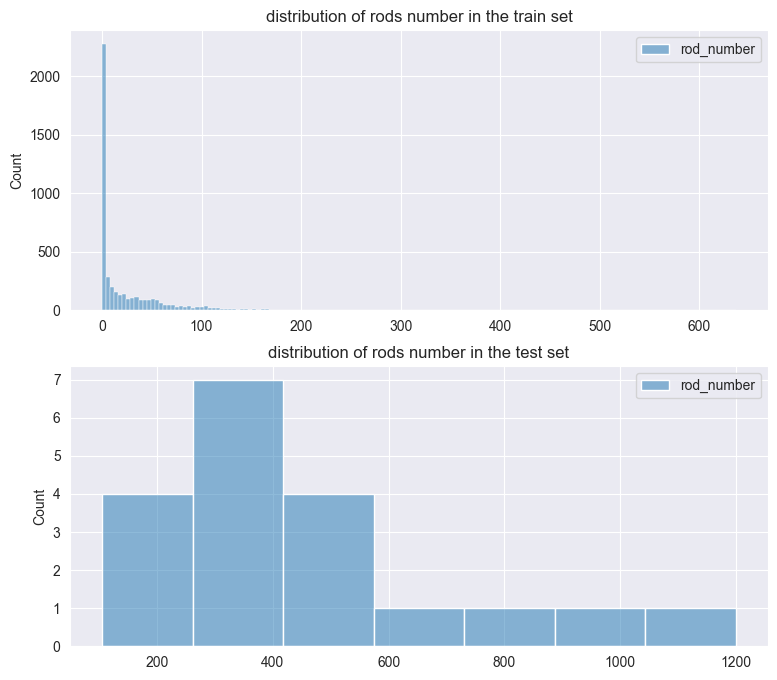

<Figure size 640x480 with 0 Axes>

In [378]:
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.title("distribution of rods number in the train set")
sns.histplot(train_data);
plt.subplot(2,1,2)
plt.title("distribution of rods number in the test set")
sns.histplot(test_data);
plt.show();
plt.tight_layout()

We see that in the test images we have twice as much rods as in train. And in train set we have positively skewed distribution.

# Data preparation

In [7]:
IMAGE_TRAIN_DIR = "segmentation_dataset/train_data"
MASKS_TRAIN_DIR = "segmentation_dataset/train_masks"

IMAGE_TEST_DIR = "segmentation_dataset/test_data/"


annot_train = "segmentation_dataset/train_data/train_labels.json"
annot_test = "segmentation_dataset/test_data/test_labels.json"

In the train set we have images 256X256, but in test set we have high resolution images of size 4160X3120. That's why in test images I will draw bigger circles

In [289]:
train_radius = 13
test_radius = 30

In [290]:
def create_masks(images_dir, masks_dir, annotation_file, radius):
	'''
	function which creates masks same size as original images from images_dir
	and draws circles in the specified coordinates from annotation_file
	all images are saved in the masks_dir
	radius - radius of circles
	color = 1
	'''

	color = 1
	radius = radius
	thickness = -1

	with open(annotation_file, 'r') as f:
		data = json.load(f)

	for image in sorted(data.keys()):
		image_name = data[image]['filename']
		file_name = os.path.join(images_dir, image_name)
		original_image = cv2.imread(file_name, 1)
		mask = np.zeros(original_image.shape[:2], dtype='uint8')

		if len(data[image]['regions'])>0:
			for idx in range(len(data[image]['regions'])):

				region = data[image]['regions'][str(idx)]

				cx = int(region["shape_attributes"]['cx'])
				cy = int(region["shape_attributes"]['cy'])



				mask = cv2.circle(mask, (cx, cy), radius, color, thickness)


		output_name = os.path.join(masks_dir, str.lower(image_name).replace(".jpg",".npy"))

		np.save(output_name, mask)



I have original images 3120 X 4160. To make patches I will divide image into patches 312 X 416.

In [291]:
def create_test_patches(images_dir, patches_dir, masks_dir, annotation_file, radius):
	'''
	function which creates masks same size as original images from images_dir
	and draws circles in the specified coordinates from annotation_file
	all images are saved in the masks_dir
	radius - radius of circles
	'''

	y_annot = [] #vector of the number of rods in new patch dataset

	color = 1
	radius = radius
	thickness = -1

	with open(annotation_file, 'r') as f:
		data = json.load(f)

	for image in sorted(data.keys()):
		cx_list=[]
		cy_list=[]
		image_name = data[image]['filename']
		file_name = os.path.join(images_dir, image_name)
		original_image = cv2.imread(file_name, 1)



		mask = np.zeros(original_image.shape[:2], dtype='uint8')

		if len(data[image]['regions'])>0:
			for idx in range(len(data[image]['regions'])):

				region = data[image]['regions'][str(idx)]

				cx = int(region["shape_attributes"]['cx'])
				cy = int(region["shape_attributes"]['cy'])

				#for counting the number of rods in each patch
				cx_list.append(cx)
				cy_list.append(cy)

				mask = cv2.circle(mask, (cx, cy), radius, color, thickness, cv2.FILLED)

		#create patches
		for j in range(0,10): #height = 312*10
			for i in range(0,10): #width = 416*10

				num_rods=0 #number of rods in that patch
				image_patch = original_image[j*312:(j+1)*312, i*416:(i+1)*416, :]

				#save image patch
				output_name = os.path.join(patches_dir, str.lower(image_name).replace(".jpg",f"_patch_{j}_{i}.jpg"))
				cv2.imwrite(output_name, image_patch)

				mask_patch = mask[j*312:(j+1)*312, i*416:(i+1)*416]
				#draw circles that get to that patch
				for (cx, cy) in zip(cx_list, cy_list):

					if (cx in range(i*416,(i+1)*416)) and (cy in range(j*312,(j+1)*312)):

						#increase number of blobs for that patch
						num_rods+=1

				#save mask
				output_name = os.path.join(masks_dir, str.lower(image_name).replace(".jpg",f"_patch_{j}_{i}.npy"))

				#save mask patch as numpy array
				np.save(output_name, mask_patch)

				#save number of rods in y_annot
				y_annot.append(num_rods)

	return y_annot





In [292]:
#create masks for train
create_masks(IMAGE_TRAIN_DIR, MASKS_TRAIN_DIR, annot_train, train_radius)

In [293]:
IMAGES_PATCHES_DIR = "segmentation_dataset/test_patches_images"
MASKS_PATCHES_DIR = "segmentation_dataset/test_patches_masks"

In [294]:
#create image and mask patches for test and annotations for sorted patches
y_annot = create_test_patches(IMAGE_TEST_DIR, IMAGES_PATCHES_DIR, MASKS_PATCHES_DIR, annot_test, test_radius)

In [295]:
print(y_annot)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 3, 0, 0, 0, 0, 0, 1, 8, 9, 9, 6, 0, 0, 0, 0, 0, 0, 9, 9, 8, 10, 1, 0, 0, 0, 0, 0, 4, 5, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 8, 10, 8, 6, 0, 0, 0, 4, 0, 7, 11, 9, 11, 13, 9, 3, 0, 5, 2, 11, 9, 11, 12, 11, 10, 1, 0, 5, 0, 4, 7, 4, 3, 4, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 4, 3, 4, 4, 2, 0, 0, 0, 6, 4, 3, 4, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 8, 7, 3, 4, 7, 9, 4, 7, 8, 9, 12, 9, 5, 8, 11, 8, 8, 11, 14, 10, 9, 11, 10, 12, 11, 10, 10, 11, 11, 10, 7, 4, 3, 6, 5, 5, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 11, 11, 9, 3, 7, 5, 4, 4, 5, 6, 6, 5, 4, 5, 5, 5, 5, 3, 7, 5, 5, 7, 5, 2, 6, 6, 4, 5, 3

### Define Model parameters

In [147]:
#1 version - efficientnet-b0'
ENCODER = 'resnet50'
ENCODER_DEPTH = 5
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['rod']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

BATCH_SIZE = 16


# create segmentation model with pretrained encoder


model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
	in_channels=3,
    encoder_weights=ENCODER_WEIGHTS,
	encoder_depth=ENCODER_DEPTH,
	activation=ACTIVATION,
	classes = len(CLASSES)

)


In [148]:
#define preprocessing for the encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

### Prepare dataset

In [296]:
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms, preprocessing):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
		self.preprocessing = preprocessing

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):

		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		maskPath = self.maskPaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode

		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


		mask = np.load(maskPath)
		mask = np.expand_dims(mask, -1)






		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			augmentations=self.transforms(image=image, mask=mask)
			image = augmentations["image"]
			mask = augmentations["mask"]







		if self.preprocessing is not None:
			image = np.array(image)
			mask = np.array(mask)
			# print(image.shape)
			# print(mask.shape)
			sample = self.preprocessing(image=image, mask=mask)
			image, mask = sample['image'], sample['mask']








		return (image, mask)

In [351]:
def get_training_augmentation():
    train_transform = [

		A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
		A.VerticalFlip(p=0.5),

		A.Sharpen(p=0.5),
		A.RandomBrightnessContrast(p=0.5),

        A.ShiftScaleRotate(scale_limit=[0.5, 1.5], rotate_limit=45, shift_limit=0.1, p=0.5, border_mode=0),

        A.Perspective(p=0.5),


      ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    val_transform = [
		A.Resize(width=256, height=256),



    ]
    return A.Compose(val_transform)

def get_test_augmentation():
	"""Add paddings to make image shape divisible by 32"""
	test_transform = [
		A.PadIfNeeded(320, 416), #padd images to be devisible by 32
	]
	return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2,0,1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
       A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

In [309]:
# load the image and mask filepaths in a sorted manner
imageTrainPaths = sorted(list(glob.glob(IMAGE_TRAIN_DIR+"/*.JPG")))
maskTrainPaths = sorted(list(glob.glob(MASKS_TRAIN_DIR+"/*.npy")))

imageTestPaths = sorted(list(glob.glob(IMAGES_PATCHES_DIR+"/*.jpg")))
maskTestPaths = sorted(list(glob.glob(MASKS_PATCHES_DIR+"/*.npy")))

In [310]:
len(imageTrainPaths)

4573

In [311]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for validation
split = train_test_split(imageTrainPaths, maskTrainPaths, test_size=0.2, random_state=42)
# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

In [312]:
len(trainImages)

3658

In [313]:
len(valImages)

915

In [314]:
trainDS = SegmentationDataset(imagePaths = trainImages, maskPaths = trainMasks,
						  transforms=get_training_augmentation(),
							  preprocessing=get_preprocessing(preprocessing_fn))

valDS = SegmentationDataset(imagePaths = valImages, maskPaths = valMasks,
						  transforms=get_validation_augmentation(),
							preprocessing=get_preprocessing(preprocessing_fn))


print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(valDS)} examples in the validation set...")

[INFO] found 3658 examples in the training set...
[INFO] found 915 examples in the validation set...


In [315]:
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE)
valLoader = DataLoader(valDS, shuffle=False, batch_size=BATCH_SIZE)

In [152]:
len(trainLoader)

229

In [153]:
def show_images_and_masks(loader):
	images, masks  = next(iter(loader))

	for image, mask in zip(images, masks):

		image = image.permute(1, 2, 0)
		mask = mask.permute(1, 2, 0)
		plt.figure(figsize=(9,8))
		plt.subplot(1, 2, 1)
		plt.imshow(image)
		plt.title("Image")
		plt.subplot(1, 2, 2)
		plt.imshow(mask, cmap="gray")
		plt.title("Mask")
		plt.axis("off")
		plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


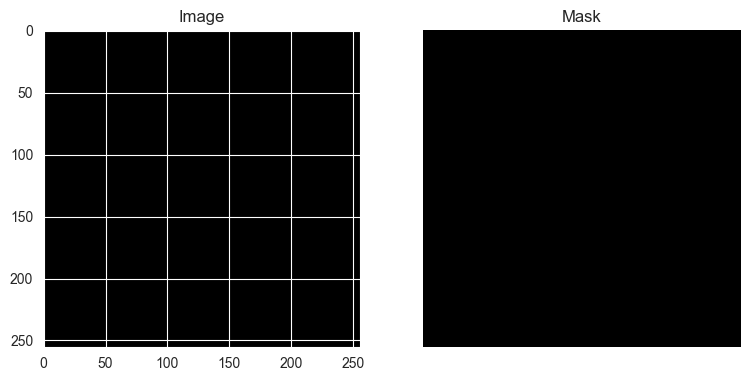

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


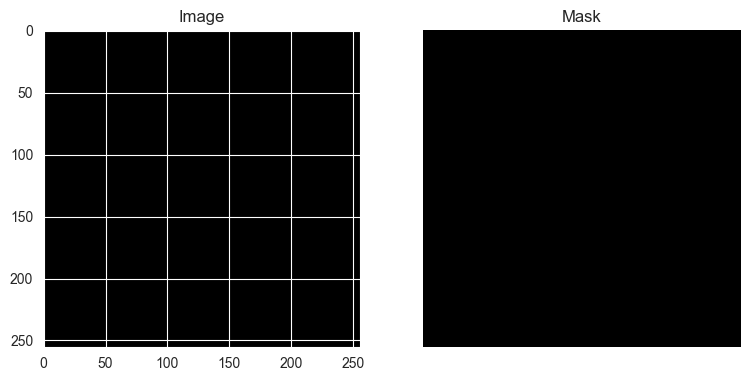

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


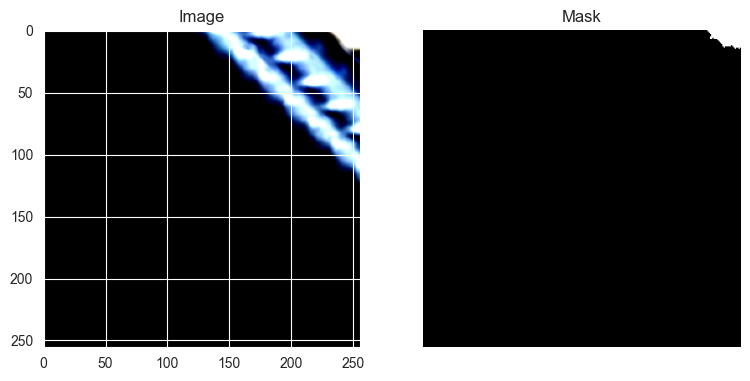

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


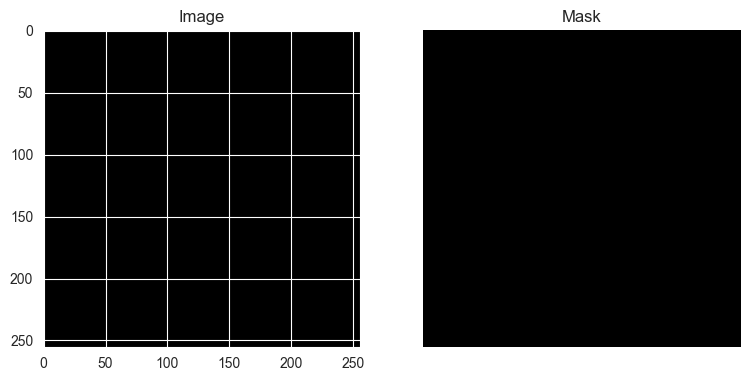

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


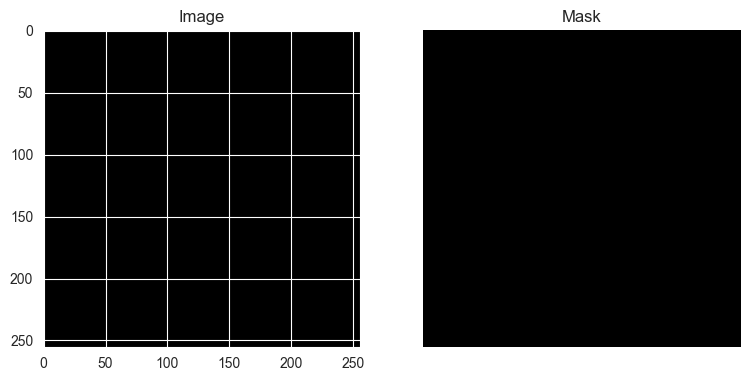

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


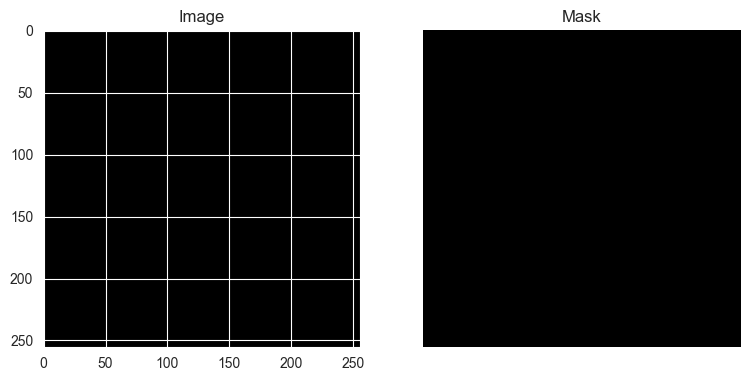

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


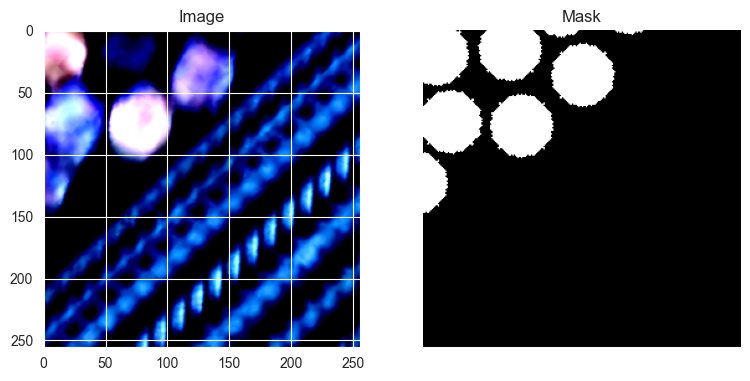

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


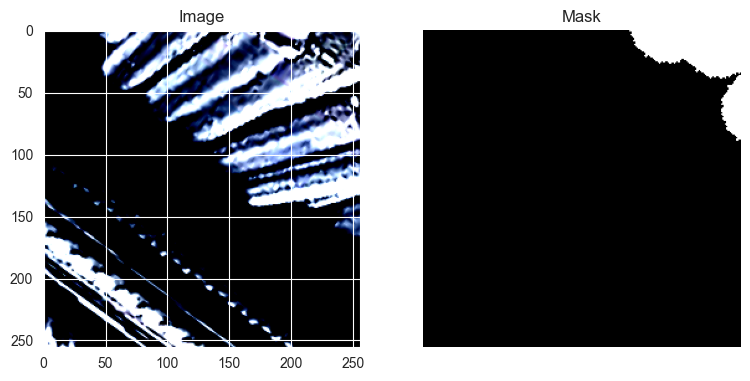

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


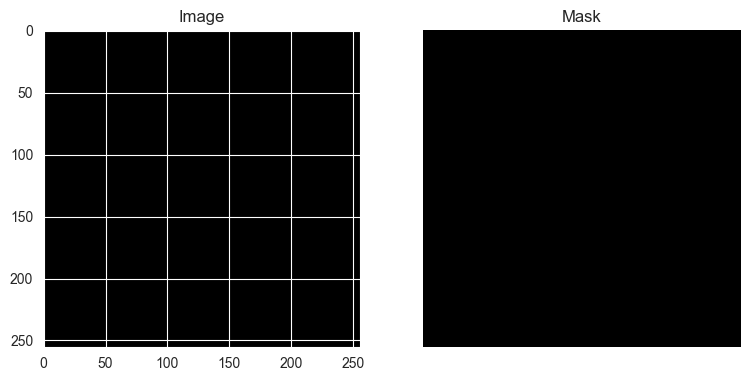

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


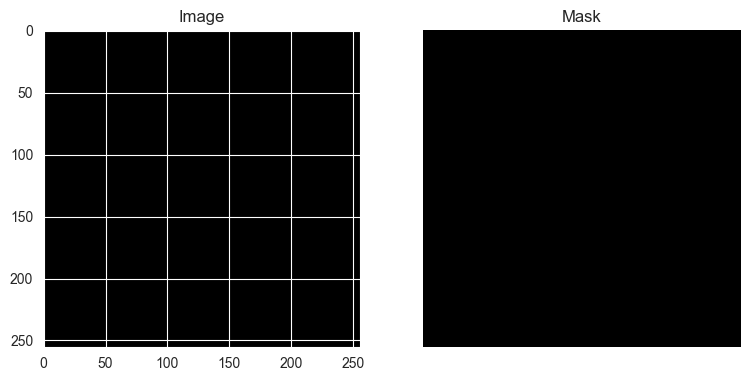

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


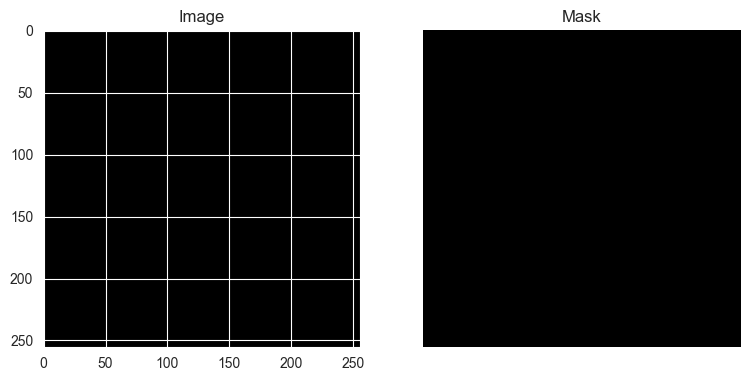

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


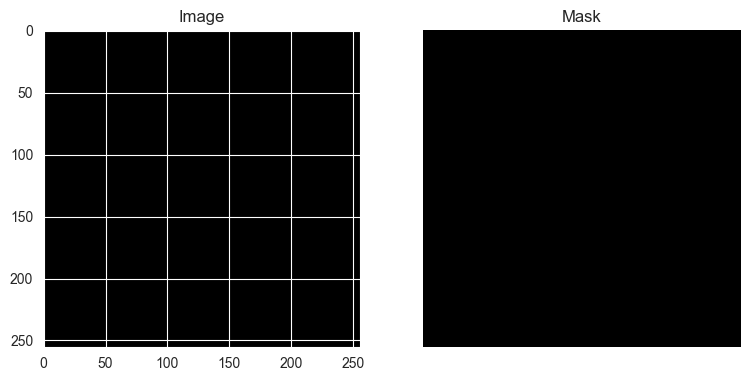

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


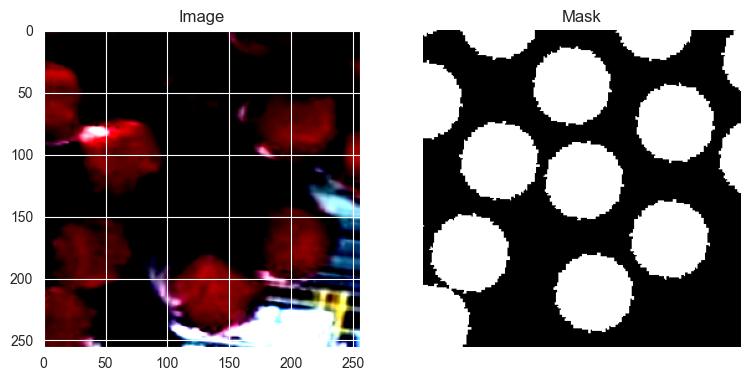

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


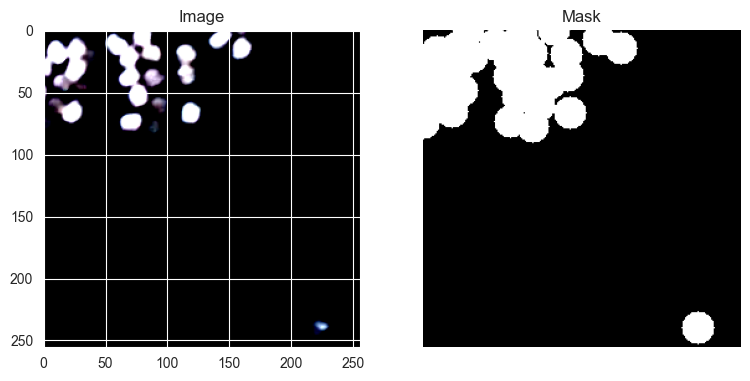

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


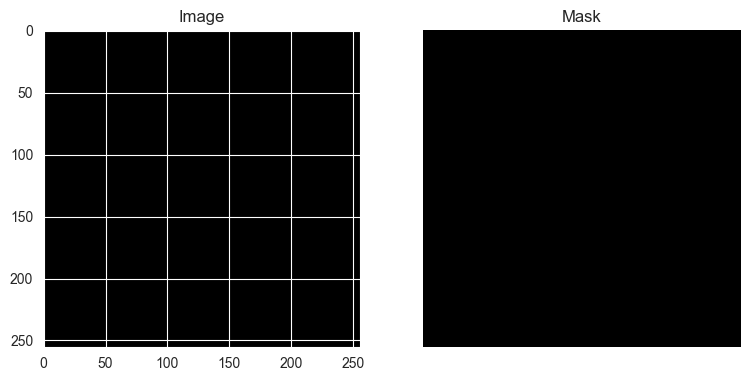

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


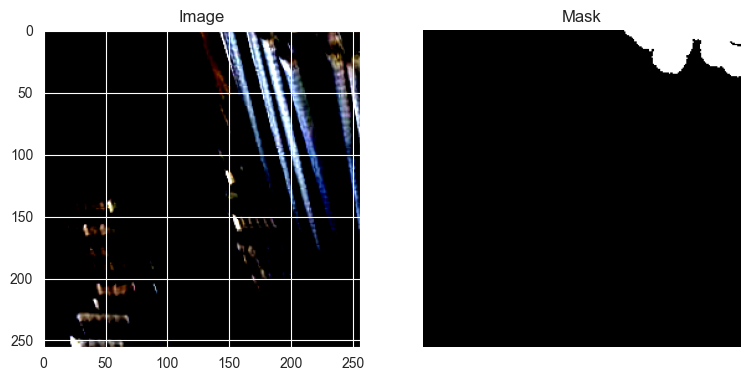

In [154]:
show_images_and_masks(trainLoader)

### Train model

### Define focal loss

In [68]:
ALPHA = 0.25
GAMMA = 2

class FocalLoss(nn.Module):
	def __init__(self, weight=None, size_average=True):
		super(FocalLoss, self).__init__()
		self.__name__ = "focal_loss"


	def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
		inputs = inputs.view(-1)
		targets = targets.view(-1)

        #first compute binary cross-entropy
		BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
		BCE_EXP = torch.exp(-BCE)
		focal_loss = alpha * (1-BCE_EXP)**gamma * BCE

		return focal_loss

In [69]:
# Set num of epochs
EPOCHS = 30

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
#loss = smp.utils.losses.BCEWithLogitsLoss(pos_weight=torch.tensor(100.))

#tried in another version
#loss = FocalLoss()

loss = smp.utils.losses.DiceLoss()

metrics = [
	smp.utils.metrics.IoU(threshold=0.5),
	smp.utils.metrics.Accuracy(threshold=0.5)
]

# define optimizer
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])



In [70]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,

)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [71]:
MODEL_DIR = "output/version3"
best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

	# Perform training & validation
	print('\nEpoch: {}'.format(i))
	train_logs = train_epoch.run(trainLoader)
	valid_logs = valid_epoch.run(valLoader)
	train_logs_list.append(train_logs)
	valid_logs_list.append(valid_logs)
	# Save model if a better val IoU score is obtained
	if best_iou_score < valid_logs['iou_score']:
		best_iou_score = valid_logs['iou_score']
		torch.save(model, f"{MODEL_DIR}/best_model.pth")
		print('Model saved!')


	if i == 10: #decrease lr
	 #change learning rate after 10 epoch
		optimizer.param_groups[0]['lr'] = 0.00001

	if i == 20: #decrease lr
	 #change learning rate after 20 epoch
		optimizer.param_groups[0]['lr'] = 0.000005




Epoch: 0
valid: 100%|██████████| 58/58 [02:24<00:00,  2.49s/it, dice_loss - 0.5426, iou_score - 0.437, accuracy - 0.8168] 
Model saved!

Epoch: 1
valid: 100%|██████████| 58/58 [02:20<00:00,  2.42s/it, dice_loss - 0.4191, iou_score - 0.6039, accuracy - 0.9095]
Model saved!

Epoch: 2
valid: 100%|██████████| 58/58 [02:20<00:00,  2.43s/it, dice_loss - 0.3153, iou_score - 0.6674, accuracy - 0.9327]
Model saved!

Epoch: 3
valid: 100%|██████████| 58/58 [02:35<00:00,  2.68s/it, dice_loss - 0.2471, iou_score - 0.7089, accuracy - 0.9461]
Model saved!

Epoch: 4
valid: 100%|██████████| 58/58 [02:21<00:00,  2.43s/it, dice_loss - 0.2095, iou_score - 0.7084, accuracy - 0.9454]

Epoch: 5
valid: 100%|██████████| 58/58 [02:22<00:00,  2.46s/it, dice_loss - 0.1896, iou_score - 0.7141, accuracy - 0.9457]
Model saved!

Epoch: 6
valid: 100%|██████████| 58/58 [02:18<00:00,  2.38s/it, dice_loss - 0.1905, iou_score - 0.7037, accuracy - 0.9417]

Epoch: 7
valid: 100%|██████████| 58/58 [02:17<00:00,  2.36s/it, di

In [74]:
train_logs_list = pd.DataFrame.from_dict(train_logs_list)
valid_logs_list = pd.DataFrame.from_dict(valid_logs_list)

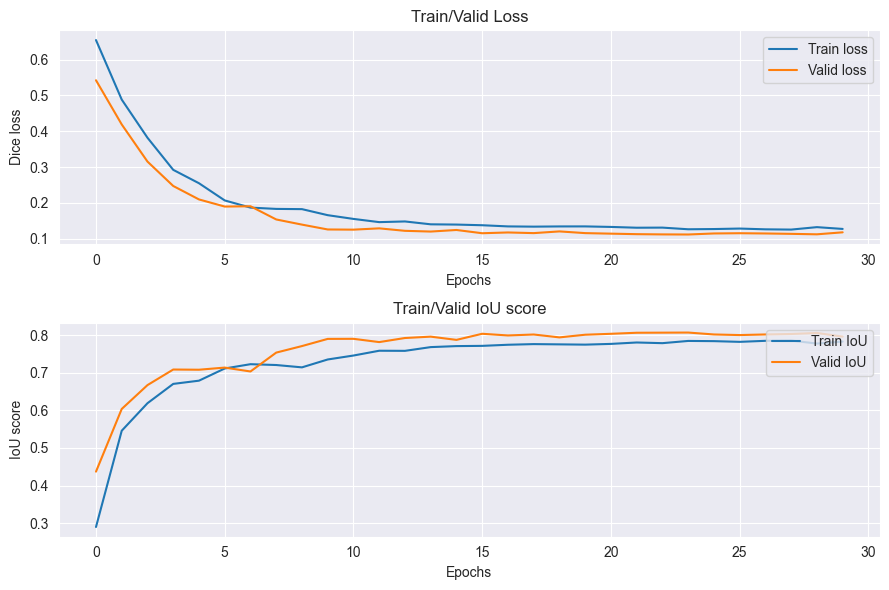

In [75]:
plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
plt.plot(train_logs_list['dice_loss'], label="Train loss")
plt.plot(valid_logs_list['dice_loss'], label="Valid loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Dice loss")
plt.title("Train/Valid Loss")

plt.subplot(2,1,2)
plt.plot(train_logs_list['iou_score'], label="Train IoU")
plt.plot(valid_logs_list['iou_score'], label="Valid IoU")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("IoU score")
plt.title("Train/Valid IoU score")

plt.tight_layout()
plt.show()

### Load best model

In [155]:
# load best saved checkpoint
best_model = torch.load('output/version3/best_model.pth')

In [220]:
# create test dataset
testDS = SegmentationDataset(imagePaths=imageTestPaths, maskPaths=maskTestPaths,
							 transforms=get_test_augmentation(),
							 preprocessing=get_preprocessing(preprocessing_fn))

print(f"[INFO] found {len(testDS)} examples in the test set...")

testLoader = DataLoader(testDS, shuffle=False, batch_size=1)

[INFO] found 1900 examples in the test set...


In [303]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(testLoader)

print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {logs['dice_loss']:.4f}")

valid: 100%|██████████| 1900/1900 [08:47<00:00,  3.60it/s, dice_loss - 0.7222, iou_score - 0.6009, accuracy - 0.922] 
Evaluation on Test Data: 
Mean IoU Score: 0.6009
Mean Dice Loss: 0.7222


### Blob detection setup

In [355]:
# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

params.filterByColor = 1
params.blobColor = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 30
#
# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.1
#
# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.1
#
# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.001

# Create a detector with the parameters
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3:
	detector = cv2.SimpleBlobDetector(params)
else:
	detector = cv2.SimpleBlobDetector_create(params)


def detect_blobs(image, show=False):
	keypoints = detector.detect(image)

	if show:
		# Draw detected blobs as red circles.
		#cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
		im_with_keypoints = cv2.drawKeypoints(image, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

		# Show keypoints
		plt.imshow(im_with_keypoints)
		plt.axis("off")
		plt.show()

	return len(keypoints)

### Visualisation of mask on some images from test

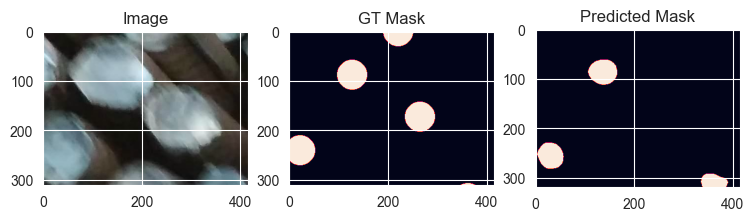

In [349]:
image = cv2.imread("segmentation_dataset/test_patches_images/photo (122)_patch_0_2.jpg")
mask = np.load("segmentation_dataset/test_patches_masks/photo (122)_patch_0_2.npy")

mask = 255*mask.astype("uint8")


plt.figure(figsize=(9, 18))
plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask)
plt.title("GT Mask")


#pad test image from 312x416 to 320x416
image = cv2.copyMakeBorder(image, 0, 8, 0, 0, cv2.BORDER_DEFAULT)

image = preprocessing_fn(image)


x_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()
pr_mask = best_model.predict(x_tensor)


pr_mask = pr_mask.squeeze().cpu().numpy()
pr_mask[pr_mask>=0.5]=1
pr_mask = 255*pr_mask.astype('uint8')

plt.subplot(1,3,3)
plt.imshow(pr_mask)
plt.title("Predicted Mask")

plt.show()


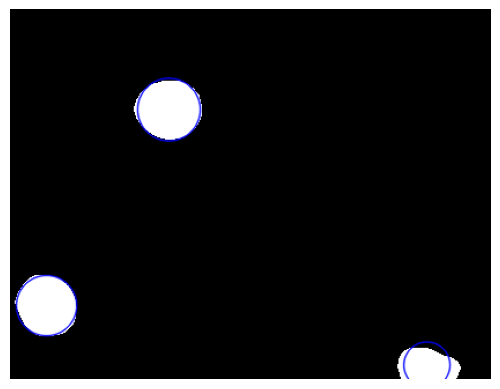

3

In [350]:
detect_blobs(pr_mask, True)

In [318]:
def prepare_plot(origImage, origMask, predMask):


	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask

	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")

	ax[0].axis("off")
	ax[1].axis("off")
	ax[2].axis("off")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()


In [356]:
def show_predictions(loader):

	font = cv2.FONT_HERSHEY_SIMPLEX
	# org
	org = (5, 20)
	# fontScale
	fontScale = 0.5
	# Blue color in BGR
	color = (255, 0, 0)
	# Line thickness of 2 px
	thickness = 1
	#kernel for erosion
	kernel = np.ones((3,3),np.uint8)

	images, gt_masks = next(iter(loader))

	for (image, gt_mask) in zip(images, gt_masks):


		image = image.squeeze().cpu().numpy()
		gt_mask = gt_mask.squeeze().cpu().numpy()
		gt_mask = 255*gt_mask.astype('uint8')

		x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

		pr_mask = best_model.predict(x_tensor)
		pr_mask = pr_mask.squeeze().cpu().numpy()
		pr_mask[pr_mask>=0.5]=1

		pr_mask = 255*pr_mask.astype('uint8')

		#make erosion before predicting blobs to separate connected blobs

		pr_mask = cv2.erode(pr_mask, kernel, iterations = 6)

		blobs_num = detect_blobs(pr_mask)



		# Using cv2.putText() method
		pr_mask = cv2.putText(pr_mask, f"num rods = {str(blobs_num)}",
								org, font, fontScale, color, thickness, cv2.LINE_AA)




		image = torch.from_numpy(image).permute(1, 2, 0).cpu().numpy()
		prepare_plot(image, gt_mask, pr_mask)

### Show predictions in train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

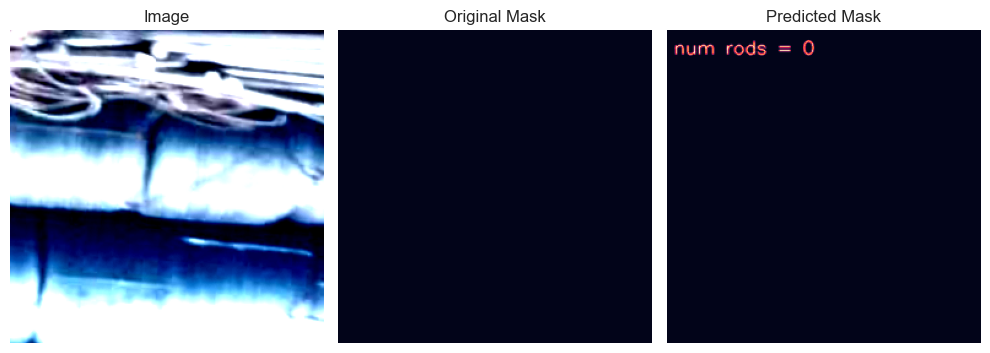

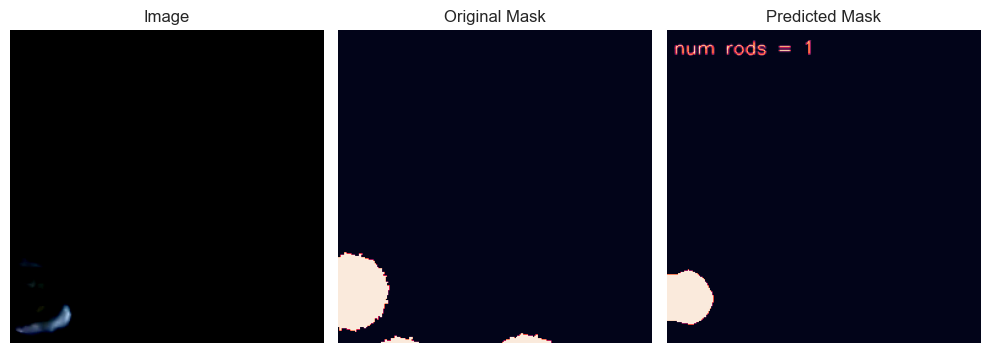

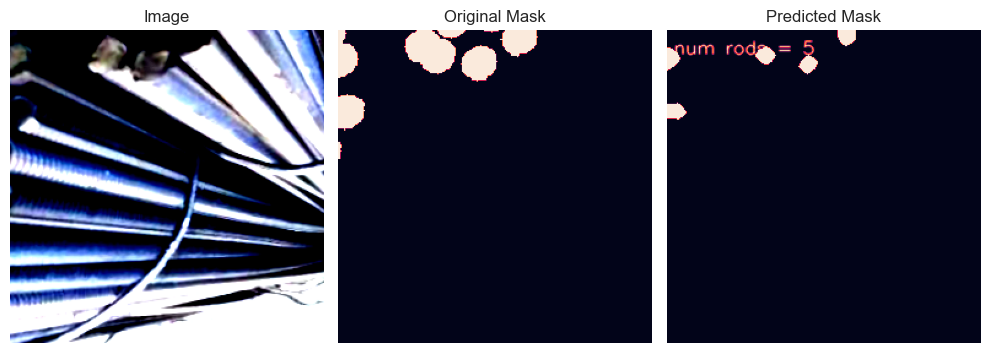

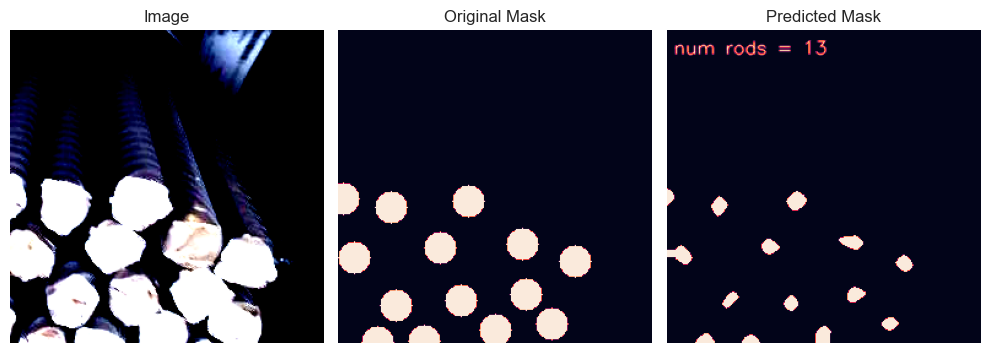

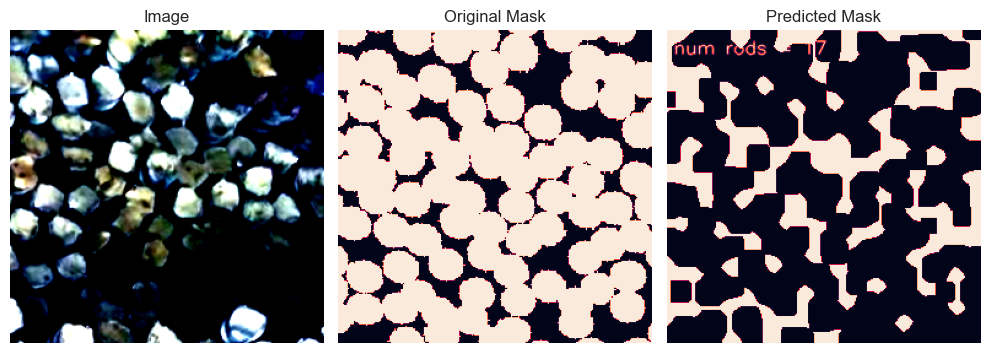

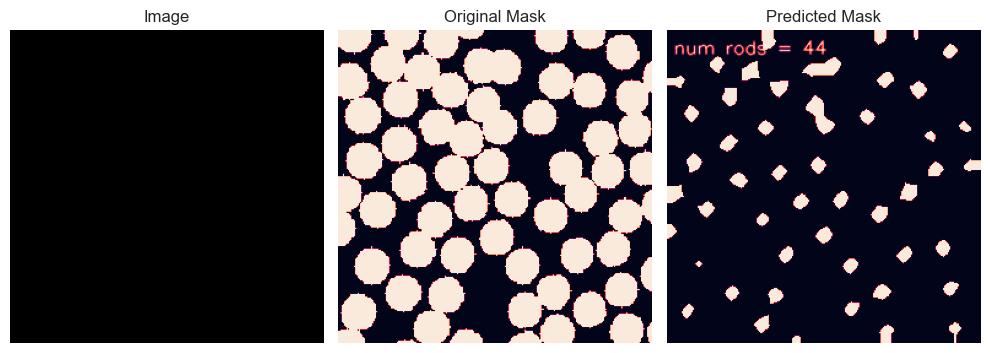

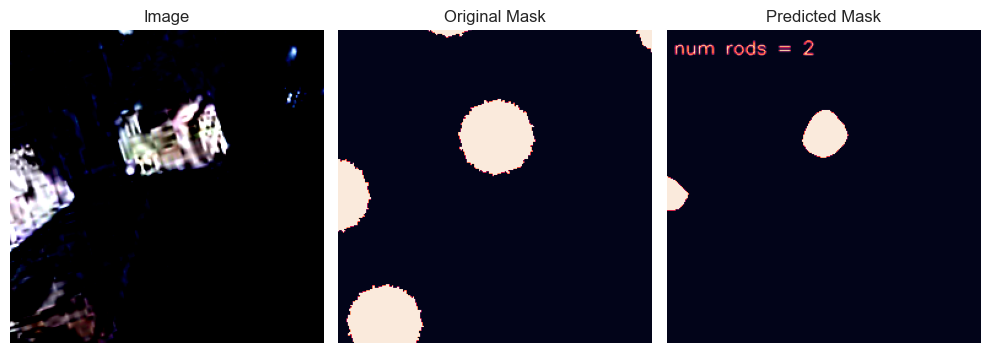

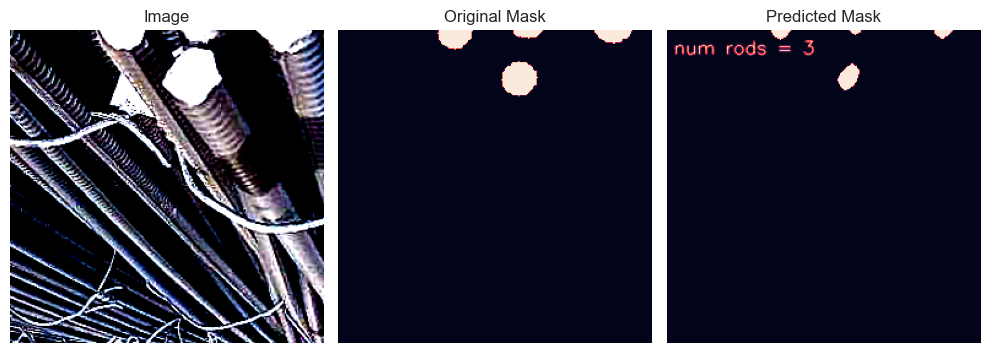

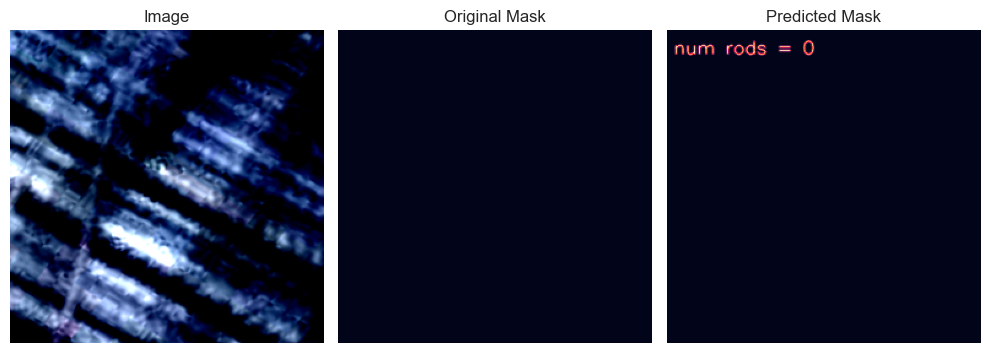

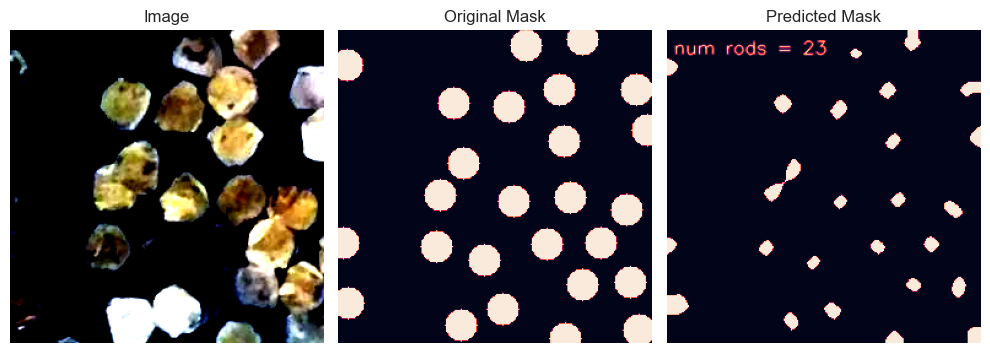

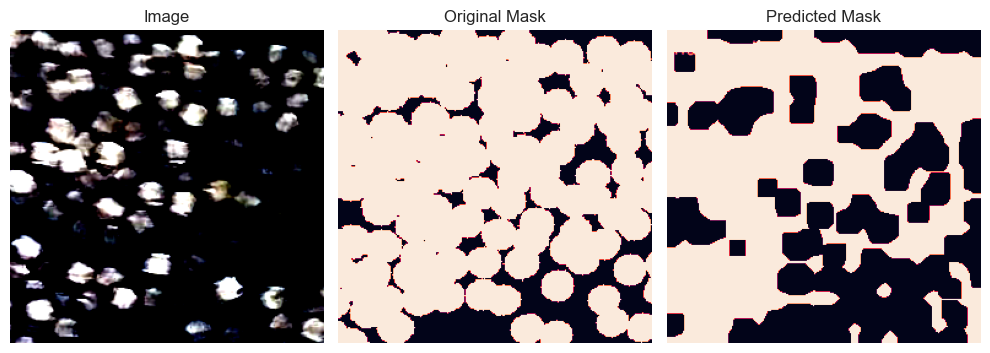

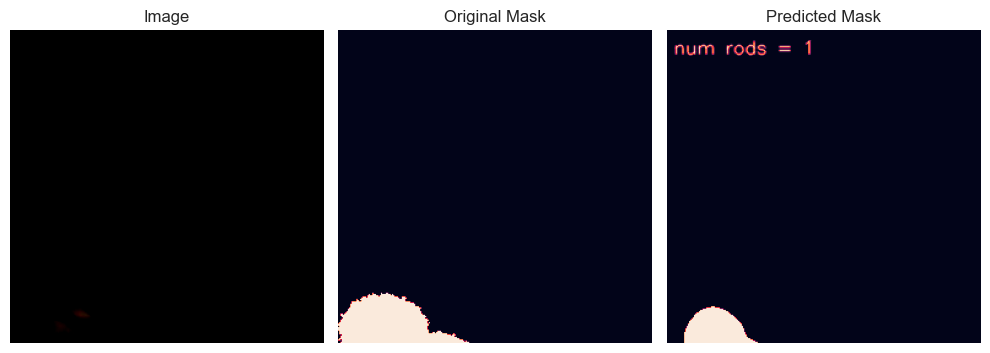

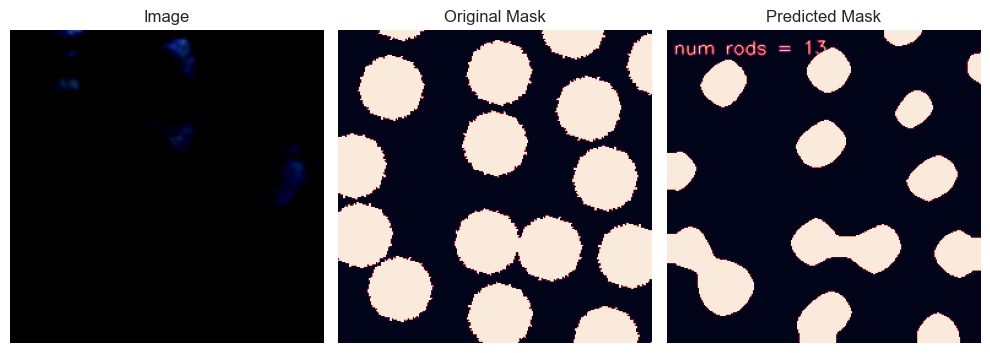

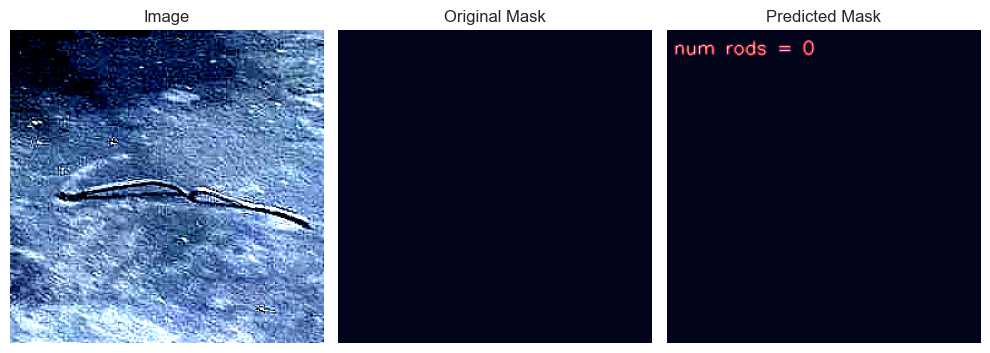

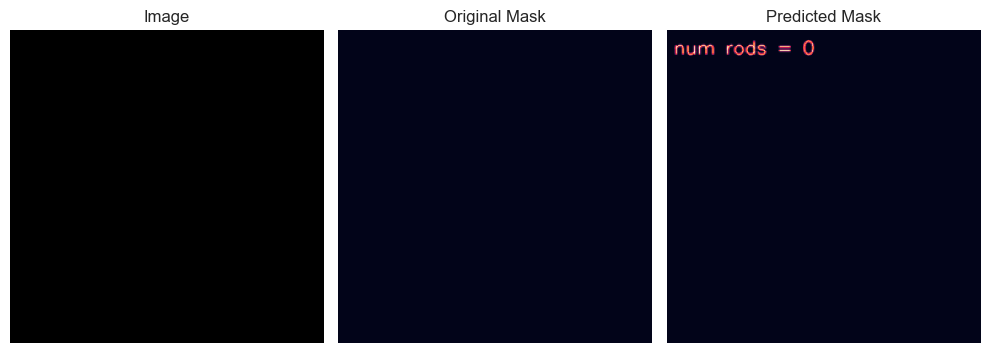

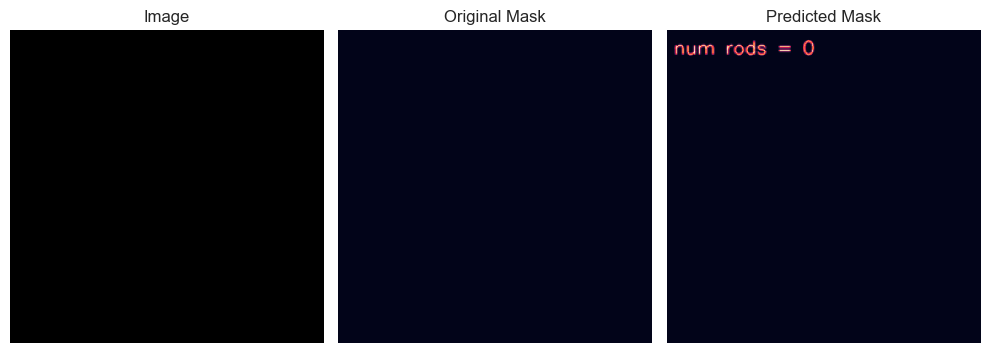

In [323]:
show_predictions(trainLoader)

### Show predictions on one batch of test

Here after applying erosion predicted masks can look different (smaller)

In [357]:
loader = DataLoader(testDS, shuffle=True, batch_size=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

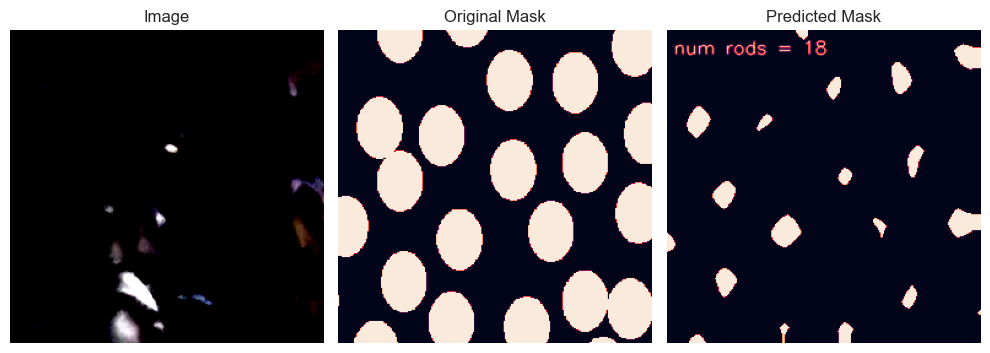

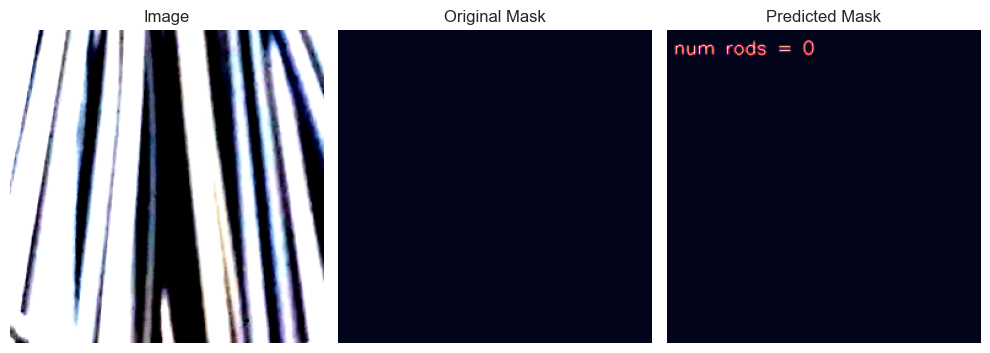

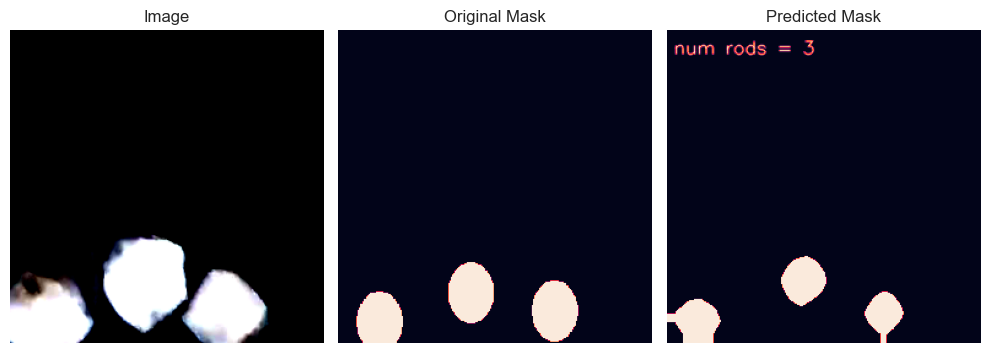

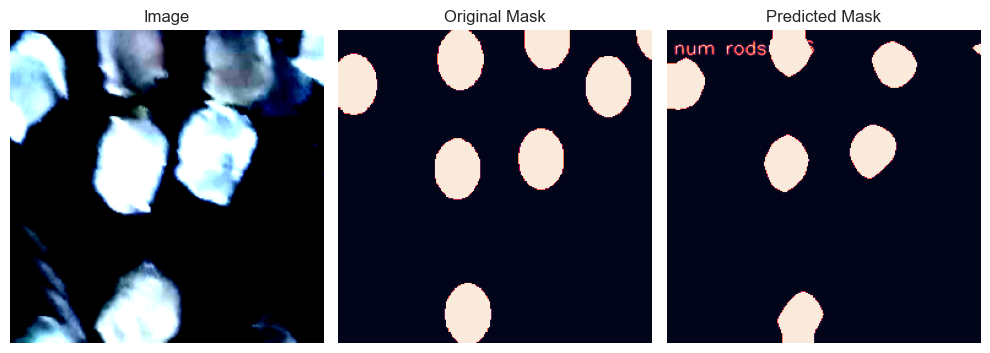

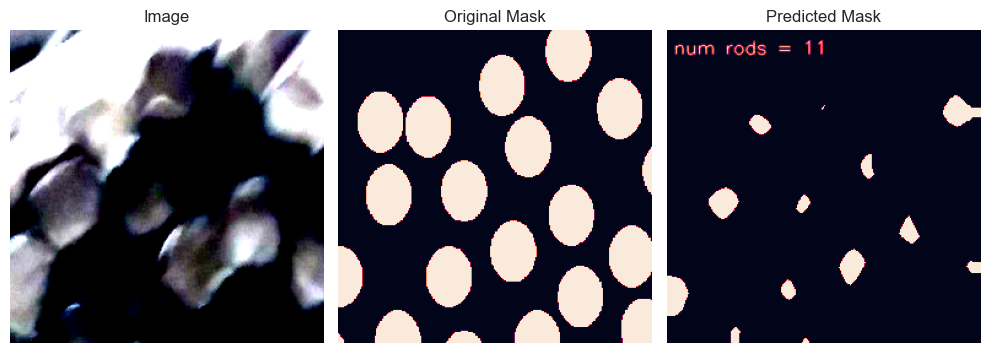

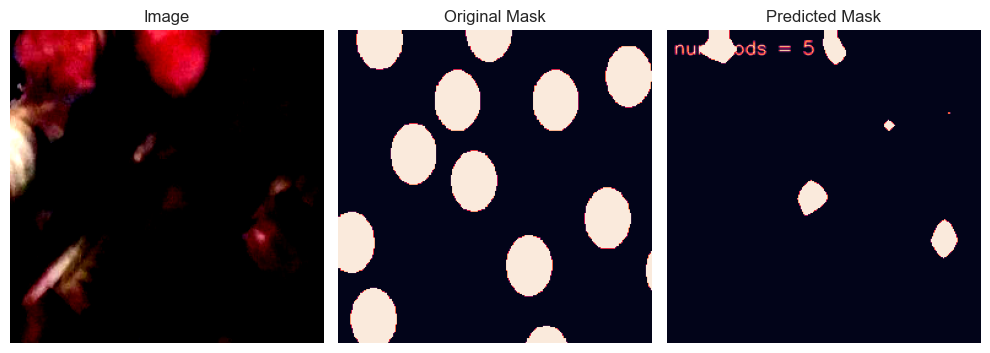

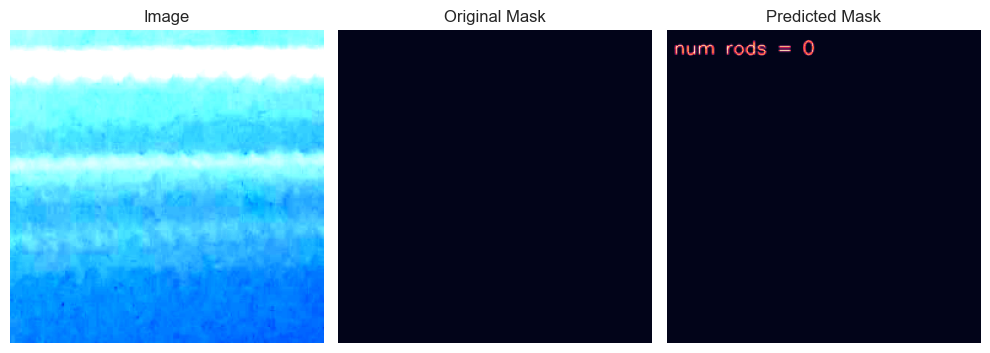

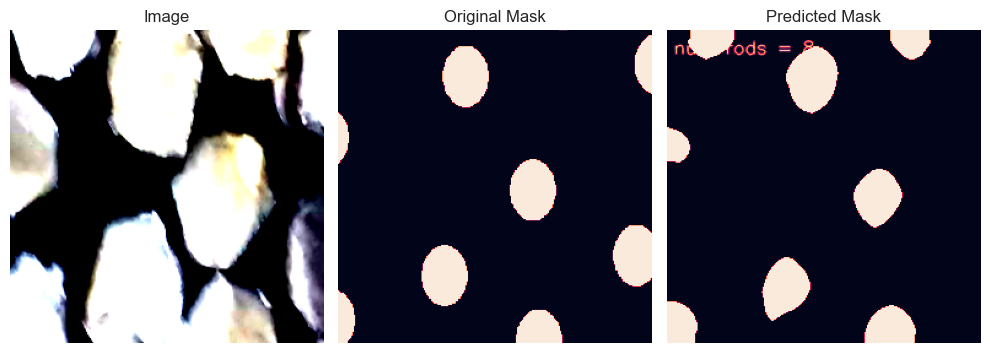

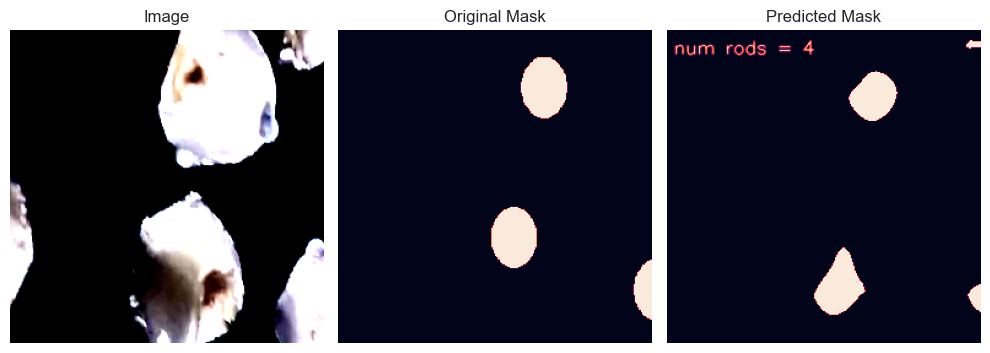

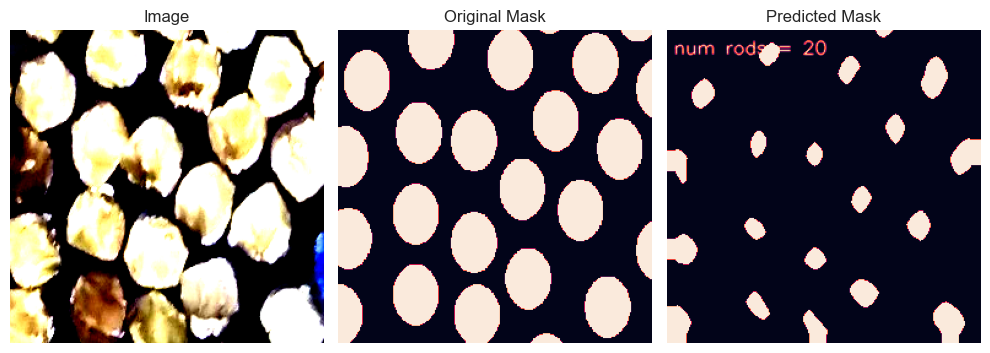

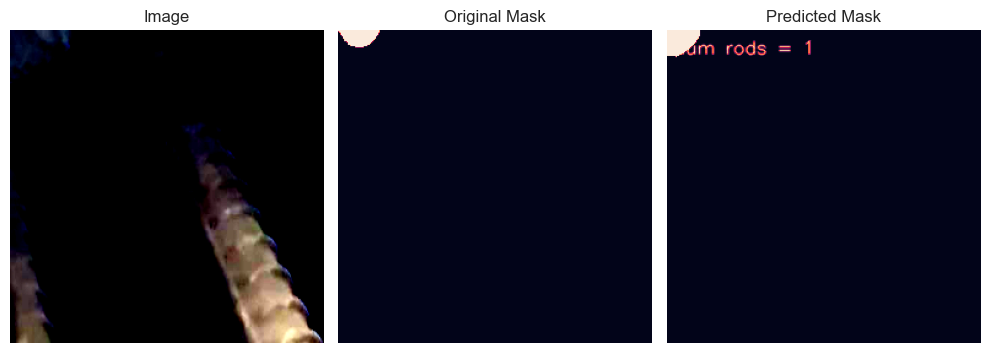

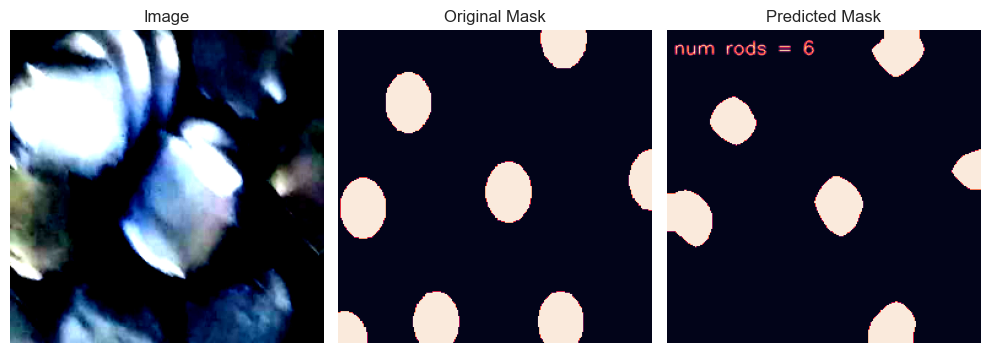

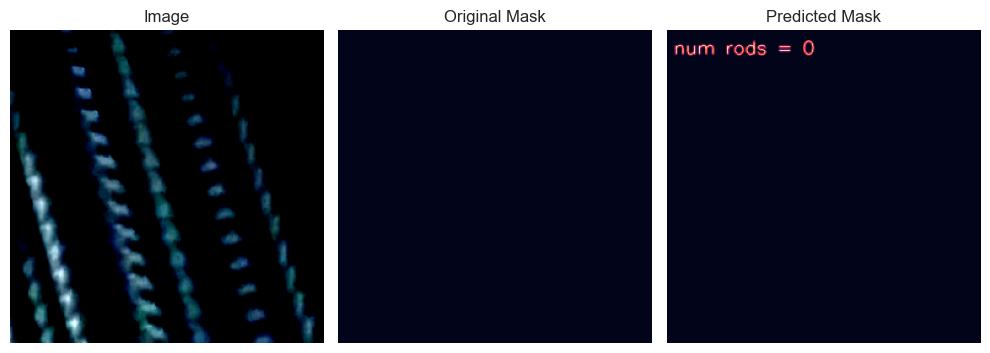

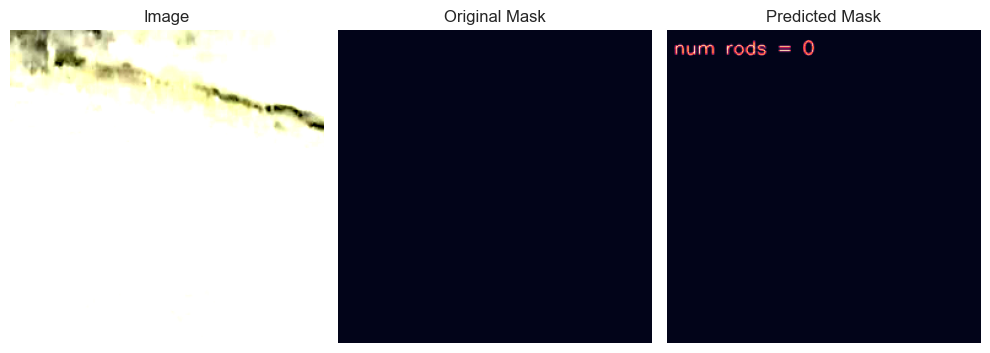

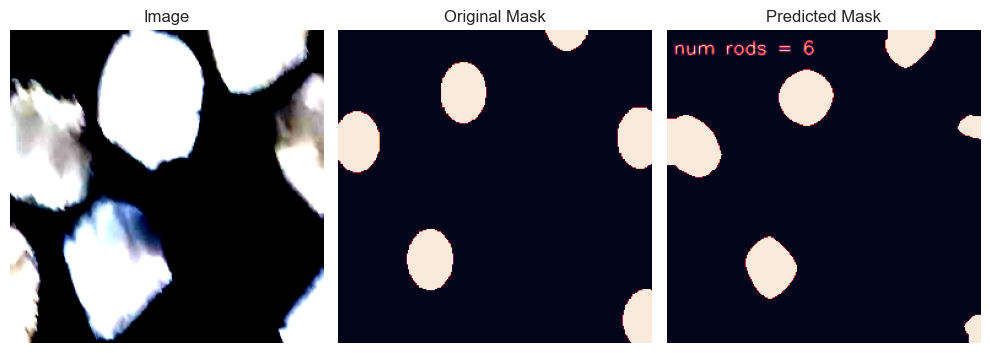

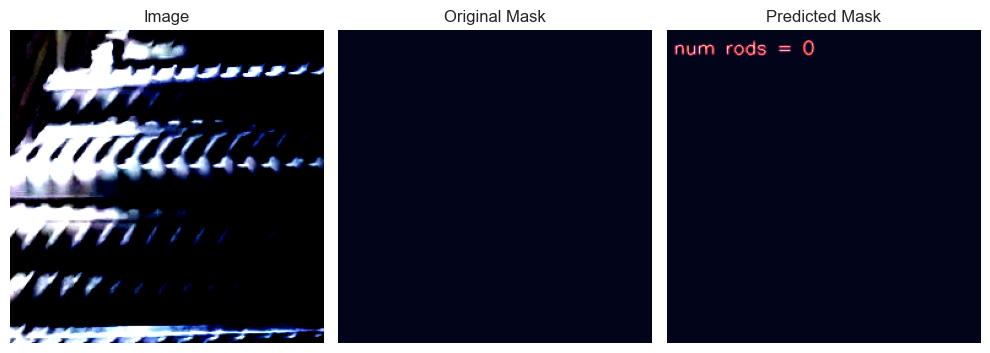

In [358]:
show_predictions(loader)

### Make predictions

In [359]:
OUT_DIR = "segmentation_dataset/predictions"


def make_predictions(testLoader, OUT_DIR):

	'''
	return y_pred - vector of predictions of number of rods
	and saves predictions to the folder OUT_DIR
	'''

	font = cv2.FONT_HERSHEY_SIMPLEX
	# org
	org = (5, 20)
	# fontScale
	fontScale = 0.5
	# Blue color in BGR
	color = (255, 0, 0)
	# Line thickness of 2 px
	thickness = 1

	#kernel for erosion
	kernel = np.ones((3,3),np.uint8)

	y_pred = []
	i=0

	for image, gt_mask in testLoader:


		image = image.squeeze().cpu().numpy()

		gt_mask = gt_mask.squeeze().cpu().numpy()
		gt_mask = 255*gt_mask.astype('uint8')
		x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

		pr_mask = best_model.predict(x_tensor)
		pr_mask = pr_mask.squeeze().cpu().numpy()
		pr_mask[pr_mask>=0.5]=1
		pr_mask = 255*pr_mask.astype('uint8')

		#make erosion
		pr_mask = cv2.erode(pr_mask, kernel, iterations = 6)

		blobs_num = detect_blobs(pr_mask)

		y_pred.append(blobs_num)

		# Using cv2.putText() method
		pr_mask = cv2.putText(pr_mask, f"num rods = {str(blobs_num)}",
							org, font, fontScale, color, thickness, cv2.LINE_AA)


		cv2.imwrite(os.path.join(OUT_DIR, f"Prediction_{i}.jpg"), pr_mask)

		i+=1

	return y_pred


In [360]:
y_pred = make_predictions(testLoader, OUT_DIR)

In [361]:
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 9, 7, 5, 0, 0, 0, 0, 0, 1, 9, 12, 13, 6, 0, 0, 0, 0, 0, 0, 10, 11, 11, 10, 3, 0, 0, 0, 0, 0, 7, 7, 8, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 8, 7, 6, 1, 0, 0, 2, 0, 10, 10, 9, 10, 10, 7, 1, 0, 5, 2, 12, 10, 11, 12, 11, 7, 3, 0, 4, 0, 5, 7, 5, 4, 6, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 8, 11, 3, 5, 8, 11, 6, 9, 10, 11, 11, 13, 10, 11, 10, 13, 10, 13, 15, 14, 12, 12, 14, 13, 13, 13, 11, 12, 15, 11, 7, 6, 4, 8, 6, 8, 2, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, 1, 12, 12, 10, 3, 8, 6, 7, 3, 6, 6, 6, 5, 5, 5, 6, 6, 5, 4, 7, 6, 8, 9, 8, 

In [329]:
print(y_annot)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 9, 3, 0, 0, 0, 0, 0, 1, 8, 9, 9, 6, 0, 0, 0, 0, 0, 0, 9, 9, 8, 10, 1, 0, 0, 0, 0, 0, 4, 5, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 5, 8, 10, 8, 6, 0, 0, 0, 4, 0, 7, 11, 9, 11, 13, 9, 3, 0, 5, 2, 11, 9, 11, 12, 11, 10, 1, 0, 5, 0, 4, 7, 4, 3, 4, 1, 0, 0, 2, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 2, 4, 3, 4, 4, 2, 0, 0, 0, 6, 4, 3, 4, 3, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 8, 7, 3, 4, 7, 9, 4, 7, 8, 9, 12, 9, 5, 8, 11, 8, 8, 11, 14, 10, 9, 11, 10, 12, 11, 10, 10, 11, 11, 10, 7, 4, 3, 6, 5, 5, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 0, 11, 11, 9, 3, 7, 5, 4, 4, 5, 6, 6, 5, 4, 5, 5, 5, 5, 3, 7, 5, 5, 7, 5, 2, 6, 6, 4, 5, 3

In [362]:
print(f"RMSE: {mean_squared_error(y_annot, y_pred, squared=False) :.4f}")

RMSE: 2.5814


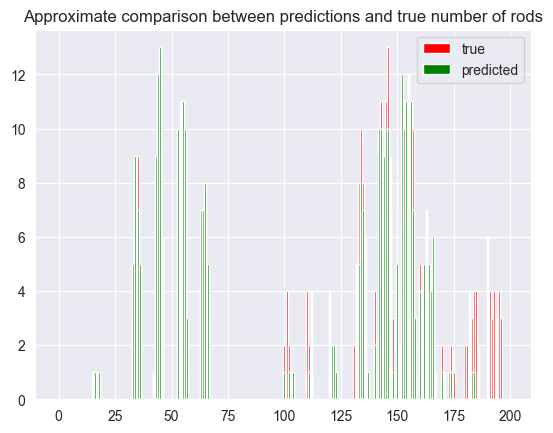

In [363]:
plt.title("Approximate comparison between predictions and true number of rods")
plt.bar(x=range(len(y_annot[:200])),height=y_annot[:200], color="red", label="true")
plt.bar(x=range(len(y_pred[:200])),height=y_pred[:200], color="green", label="predicted")

plt.legend(loc = "upper right")
plt.show()

Collect number of rods by summing up number in 100 consecutive patches (we had 10 by 10 division of single image into patches)

In [364]:
y_pred_collected = []
for i in range(0, 1900, 100):
	y_pred_collected.append(np.sum(y_pred[i:i+100]))

In [365]:
len(y_pred_collected)

19

In [366]:
y_pred_collected

[142,
 211,
 442,
 637,
 55,
 480,
 454,
 857,
 435,
 649,
 157,
 1018,
 146,
 167,
 264,
 442,
 502,
 354,
 482]

In [367]:
#sort test_data by index to have the same order of images!!!
test_data=test_data.sort_index(ascending=True)

In [368]:
y_test_true = test_data['rod_number'].values

In [369]:
print(f"MAPE: {mean_absolute_percentage_error(y_test_true, y_pred_collected) :.2f}")

MAPE: 0.20
